# Imports

In [319]:
import pandas

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

import os
import requests
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding, LSTM, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import Constant

# Display Options
pd.options.display.float_format = '{:,.2f}'.format

#Variables
MAX_SEQUENCE_LENGTH = 700
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 100

In [320]:
dataset = pandas.read_csv('askscience_data.csv')

# EDA

In [321]:
dataset.head()

,Unnamed: 0,title,body,tag,datetime,author,score,upvote_ratio,url
0,0,Post viral cough: why does it get worse after ...,Tl;dr: why is your cough during an upper respi...,Human Body,2022-12-09 02:52:07,CarboniferousCreek,"1,343.00",0.93,https://www.reddit.com/r/askscience/comments/z...
1,1,Can an x-ray of an adult show chronic malnouri...,If a person was chronically undernourished thr...,Human Body,2022-12-08 18:28:51,Foxs-In-A-Trenchcoat,426.00,0.91,https://www.reddit.com/r/askscience/comments/z...
2,2,[META] Bots and AI tools on r/askscience,\n\nOver the past few days we have seen a sur...,META,2022-12-08 09:04:25,AskScienceModerator,"2,218.00",0.92,https://www.reddit.com/r/askscience/comments/z...
3,3,Can you predictably manipulate a magnetic gas?,Does there exist a gas that changes in respons...,Physics,2022-12-08 20:01:53,hufsa7,48.00,0.83,https://www.reddit.com/r/askscience/comments/z...
4,4,Are there cells in humans (or other mammals) t...,NaN,Medicine,2022-12-09 01:11:34,Velym,14.00,0.89,https://www.reddit.com/r/askscience/comments/z...


In [322]:
dataset.describe()

,Unnamed: 0,score,upvote_ratio
count,"4,205.00","4,205.00","4,205.00"
mean,"1,404.25","3,730.47",0.77
std,815.52,"5,577.61",0.18
min,0.00,0.00,0.17
25%,676.00,4.00,0.59
50%,"1,491.00",35.00,0.84
75%,"2,136.00","7,472.00",0.92
max,"2,735.00","83,382.00",1.00


In [323]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4205 entries, 0 to 4204
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    4205 non-null   int64  
 1   title         4205 non-null   object 
 2   body          2492 non-null   object 
 3   tag           4011 non-null   object 
 4   datetime      4205 non-null   object 
 5   author        4205 non-null   object 
 6   score         4205 non-null   float64
 7   upvote_ratio  4205 non-null   float64
 8   url           4205 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 295.8+ KB


<ipython-input-324-9b6eb8eeedc6>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scores);


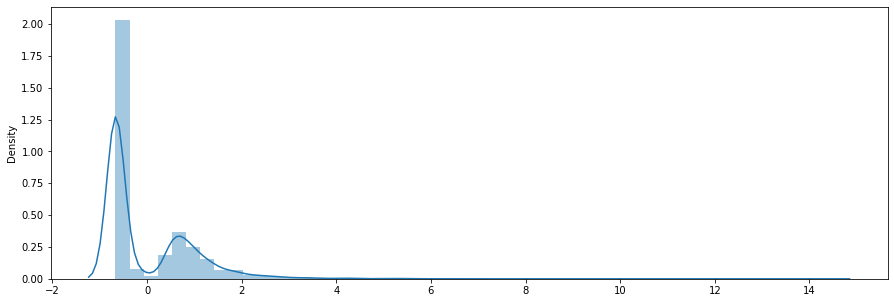

In [324]:
scaler = StandardScaler()
scores = scaler.fit_transform(dataset.score.values.reshape(-1,1))

plt.figure(figsize=(15, 5))
sns.distplot(scores);

# attributes of a successful post

In [325]:
import spacy #load spacy
from spacy.cli.download import download
download(model="en_core_web_sm")

nlp = spacy.load("en_core_web_sm", disable=['parser', 'tagger', 'ner'])
stops = nlp.Defaults.stop_words


def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)


dataset['cleaned_body'] = dataset['body'].astype(str).apply(normalize, lowercase=True, remove_stopwords=True)
dataset['cleaned_title'] = dataset['title'].astype(str).apply(normalize, lowercase=True, remove_stopwords=True)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


/usr/local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [326]:
dataset = dataset.dropna()

In [327]:
dataset.iloc[0]

Unnamed: 0                                                       0
title            Post viral cough: why does it get worse after ...
body             Tl;dr: why is your cough during an upper respi...
tag                                                     Human Body
datetime                                       2022-12-09 02:52:07
author                                          CarboniferousCreek
score                                                     1,343.00
upvote_ratio                                                  0.93
url              https://www.reddit.com/r/askscience/comments/z...
cleaned_body     tl;dr : cough upper respiratory infection bad ...
cleaned_title                    post viral cough : worse better ?
Name: 0, dtype: object

In [328]:
dataset['datetime'] = pd.to_datetime(dataset['datetime'], errors='coerce')

In [329]:
dataset['day_of_week'] = dataset['datetime'].dt.day_name()

In [330]:
dataset['hour'] = dataset['datetime'].dt.hour

In [331]:
dataset['body_len'] = dataset['body'].str.len()
dataset['title_len'] = dataset['title'].str.len()

In [332]:
dataset.iloc[0]

Unnamed: 0                                                       0
title            Post viral cough: why does it get worse after ...
body             Tl;dr: why is your cough during an upper respi...
tag                                                     Human Body
datetime                                       2022-12-09 02:52:07
author                                          CarboniferousCreek
score                                                     1,343.00
upvote_ratio                                                  0.93
url              https://www.reddit.com/r/askscience/comments/z...
cleaned_body     tl;dr : cough upper respiratory infection bad ...
cleaned_title                    post viral cough : worse better ?
day_of_week                                                 Friday
hour                                                             2
body_len                                                      1544
title_len                                                     

In [333]:
unique_tags = dataset['tag'].unique()
len(unique_tags)

29

In [334]:
unique_authors = dataset['author'].unique()
len(unique_authors)

2129

In [335]:
import pandas as pd

dataset['tag'] = pd.Categorical(dataset.tag)
dataset['author'] = pd.Categorical(dataset.author)
dataset['day_of_week'] = pd.Categorical(dataset.day_of_week)

In [336]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 4203
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     2344 non-null   int64         
 1   title          2344 non-null   object        
 2   body           2344 non-null   object        
 3   tag            2344 non-null   category      
 4   datetime       2344 non-null   datetime64[ns]
 5   author         2344 non-null   category      
 6   score          2344 non-null   float64       
 7   upvote_ratio   2344 non-null   float64       
 8   url            2344 non-null   object        
 9   cleaned_body   2344 non-null   object        
 10  cleaned_title  2344 non-null   object        
 11  day_of_week    2344 non-null   category      
 12  hour           2344 non-null   int64         
 13  body_len       2344 non-null   int64         
 14  title_len      2344 non-null   int64         
dtypes: category(3), datet

In [337]:
dataset.head()

,Unnamed: 0,title,body,tag,datetime,author,score,upvote_ratio,url,cleaned_body,cleaned_title,day_of_week,hour,body_len,title_len
0,0,Post viral cough: why does it get worse after ...,Tl;dr: why is your cough during an upper respi...,Human Body,2022-12-09 02:52:07,CarboniferousCreek,"1,343.00",0.93,https://www.reddit.com/r/askscience/comments/z...,tl;dr : cough upper respiratory infection bad ...,post viral cough : worse better ?,Friday,2,1544,61
1,1,Can an x-ray of an adult show chronic malnouri...,If a person was chronically undernourished thr...,Human Body,2022-12-08 18:28:51,Foxs-In-A-Trenchcoat,426.00,0.91,https://www.reddit.com/r/askscience/comments/z...,"person chronically undernourished childhood , ...",x - ray adult chronic malnourishment childhood ?,Thursday,18,241,66
2,2,[META] Bots and AI tools on r/askscience,\n\nOver the past few days we have seen a sur...,META,2022-12-08 09:04:25,AskScienceModerator,"2,218.00",0.92,https://www.reddit.com/r/askscience/comments/z...,past days seen surge accounts bots / ai tools ...,[ meta ] bots ai tools r / askscience,Thursday,9,522,40
3,3,Can you predictably manipulate a magnetic gas?,Does there exist a gas that changes in respons...,Physics,2022-12-08 20:01:53,hufsa7,48.00,0.83,https://www.reddit.com/r/askscience/comments/z...,exist gas changes response magnetic fields sur...,predictably manipulate magnetic gas ?,Thursday,20,547,46
6,6,Why are there carnivores plants?,Why did carnivores plants evolve? They take ni...,Biology,2022-12-09 13:06:01,rahul1739,0.00,0.50,https://www.reddit.com/r/askscience/comments/z...,carnivores plants evolve ? nitrogen insects tr...,carnivores plants ?,Friday,13,232,32


In [338]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

dataset = dataset[['tag', 'hour', 'day_of_week', 'upvote_ratio', 'body_len', 'title_len']]
categorical_columns = ['tag', 'hour', 'day_of_week']
numerical_columns = ['score', 'body_len', 'title_len']

for cat_col in categorical_columns:
    # Get one hot encoding of columns 
    one_hot = pd.get_dummies(dataset[cat_col])
    # Drop column B as it is now encoded
    dataset = dataset.drop(cat_col,axis = 1)
    # Join the encoded df
    dataset = dataset.join(one_hot)

In [339]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 4203
Data columns (total 63 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   upvote_ratio                 2344 non-null   float64
 1   body_len                     2344 non-null   int64  
 2   title_len                    2344 non-null   int64  
 3     Linguistics                2344 non-null   uint8  
 4   Anthropology                 2344 non-null   uint8  
 5   Archaeology                  2344 non-null   uint8  
 6   Astronomy                    2344 non-null   uint8  
 7   Biology                      2344 non-null   uint8  
 8   CERN AMA                     2344 non-null   uint8  
 9   COVID-19                     2344 non-null   uint8  
 10  Chemistry                    2344 non-null   uint8  
 11  Computing                    2344 non-null   uint8  
 12  Dog Cognition AMA            2344 non-null   uint8  
 13  Earth Sciences    

In [340]:
dataset.head()

,upvote_ratio,body_len,title_len,Linguistics,Anthropology,Archaeology,Astronomy,Biology,CERN AMA,COVID-19,...,21,22,23,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0.93,1544,61,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0.91,241,66,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.92,522,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.83,547,46,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0.50,232,32,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [341]:
X = dataset.loc[:, dataset.columns != 'upvote_ratio']
y = dataset['upvote_ratio']

In [342]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [343]:
rf_regr = RandomForestRegressor(max_depth=50, random_state=0, n_estimators = 150)
rf_regr.fit(X_train, y_train)




RandomForestRegressor(max_depth=50, n_estimators=150, random_state=0)

In [344]:
y_pred = rf_regr.predict(X_test)

In [345]:
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.172646931630282

In [346]:
mse

0.02980696300135127

In [347]:
rf_regr.feature_importances_

array([2.29394366e-01, 2.12294765e-01, 1.07306072e-03, 6.62284863e-04,
       5.14500895e-04, 1.21677330e-02, 1.66221764e-02, 2.11077191e-05,
       1.48684754e-02, 1.10793779e-02, 5.92080354e-03, 0.00000000e+00,
       1.18230923e-02, 1.95786663e-03, 8.04416436e-03, 2.20885793e-05,
       1.65691028e-02, 1.27637613e-03, 1.69600028e-03, 6.72507402e-05,
       2.41070222e-04, 1.74914053e-02, 1.22282398e-02, 9.87780677e-05,
       6.05248109e-03, 2.49960539e-03, 1.75582110e-02, 6.28637712e-03,
       6.20915557e-04, 9.49596518e-03, 7.86780191e-03, 3.63625742e-03,
       6.84773233e-03, 7.50774399e-03, 1.12784915e-02, 1.13776095e-02,
       1.27994804e-02, 1.03690755e-02, 1.26491332e-02, 1.33613577e-02,
       1.21910218e-02, 1.39658161e-02, 1.39831232e-02, 9.61901585e-03,
       1.35301832e-02, 1.08414090e-02, 8.96344275e-03, 9.80905785e-03,
       8.48990625e-03, 8.44444491e-03, 1.27471942e-02, 7.82768905e-03,
       1.17431168e-02, 9.74734448e-03, 1.15199876e-02, 1.64136124e-02,
      

In [348]:
feature_names = list(map(str, list(dataset.loc[:, dataset.columns != 'upvote_ratio'].columns)))

In [349]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(feature_names, rf_regr.feature_importances_):
    feats[feature] = importance #add the name/value pair 
    
{k: v for k, v in sorted(feats.items(), key=lambda item: item[1], reverse=True)}

{'body_len': 0.229394365569026,
 'title_len': 0.21229476456755805,
 'Thursday': 0.01949386413943955,
 'Wednesday': 0.0176750259741936,
 'Physics': 0.017558211042623832,
 'Mathematics': 0.017491405319224593,
 'Tuesday': 0.017331612581846963,
 'Saturday': 0.017024038715851383,
 'Biology': 0.01662217635214312,
 'Human Body': 0.016569102791483614,
 'Friday': 0.0164136124040124,
 'Sunday': 0.016369910988527667,
 'Monday': 0.01592685759726453,
 'COVID-19': 0.014868475378313116,
 '11': 0.013983123232507975,
 '10': 0.013965816081980413,
 '13': 0.01353018324453545,
 '8': 0.013361357709769017,
 '5': 0.01279948035933532,
 '19': 0.012747194231372352,
 '7': 0.012649133190113225,
 'Medicine': 0.012228239808640623,
 '9': 0.012191021812280883,
 'Astronomy': 0.01216773302169952,
 'Earth Sciences': 0.011823092281313612,
 '21': 0.011743116823772066,
 '23': 0.011519987560678768,
 '4': 0.01137760948833967,
 '3': 0.011278491466556708,
 'Chemistry': 0.01107937791447754,
 '14': 0.010841409018345327,
 '6': 0.0

upvote_ratio was used as a measure of how successful a post is. Since the value was in between [0,1] it looked like (upvotes/(upvotes+downvotes)) this ratio is risky because is 2/1 the same as 200/100 ? if that is not the worry then the approach works well. If the two ratios have different meanings then we can smooth out the data by adding the avg(upvotes) to numerator and avg(total_votes) to the denominator - a precursor of sorts to Bayesian. 

Attributes with high importance:
1. The length of the body is the most important attribute
2. Day of the week and hour at which it was posted plays a role
3. Mathematics looks like a very popular tag

More things to try out

1. GloVe embeddings of all the words in the body and title
2. Only tried RandomForest Regressor but can try Linear, KNN to compare and contrast
3. POS tagging and number of positive and negative words in the body can help a lot too.

# a model that can predict the score of a post on r/askscience

In [278]:
dataset = pandas.read_csv('askscience_data.csv')

In [279]:
dataset.columns

Index(['Unnamed: 0', 'title', 'body', 'tag', 'datetime', 'author', 'score',
       'upvote_ratio', 'url'],
      dtype='object')

In [280]:
dataset = dataset.dropna()

In [281]:
import scipy.sparse as sp

vectorizer = CountVectorizer()
title_vectorizer = vectorizer.fit_transform(dataset['title'])
body_vectorizer = vectorizer.fit_transform(dataset['body'])

title_vectorizer[0][0], tag_vectorizer[0][0]
combined_title_body = sp.hstack([title_vectorizer, body_vectorizer], format='csr')

In [283]:
X_train, X_test, y_train, y_test = train_test_split(combined_title_body, 
                                                    dataset['upvote_ratio'], test_size=0.2, random_state=42)

In [284]:
rf_regr = RandomForestRegressor(max_depth=50, random_state=0, n_estimators = 150)
rf_regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, n_estimators=150, random_state=0)

In [285]:
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.1801853590141011

In [286]:
y_pred

array([0.86333333, 0.65293952, 0.73093333, 0.66053333, 0.78606667,
       0.767     , 0.72166667, 0.80206667, 0.5408    , 0.74273333,
       0.74911667, 0.7402    , 0.61653333, 0.69706667, 0.72166667,
       0.76173333, 0.79890485, 0.84473333, 0.78033333, 0.78014286,
       0.69726667, 0.59953333, 0.81053333, 0.8272    , 0.84757333,
       0.78585556, 0.81752778, 0.79306667, 0.66733333, 0.639     ,
       0.76313333, 0.62526667, 0.66746667, 0.64993333, 0.59713333,
       0.79113333, 0.4924    , 0.82466667, 0.62246667, 0.6236    ,
       0.77066667, 0.50546667, 0.75426667, 0.78821818, 0.79433333,
       0.7772    , 0.65973333, 0.83406667, 0.76151667, 0.801     ,
       0.75051   , 0.6402    , 0.545     , 0.70093333, 0.80586667,
       0.69566667, 0.66266667, 0.75873333, 0.78666667, 0.75366667,
       0.7346    , 0.77406667, 0.8101    , 0.5682    , 0.789175  ,
       0.71042667, 0.8911746 , 0.84246667, 0.87266667, 0.753     ,
       0.75293333, 0.726     , 0.7803    , 0.74470794, 0.576  

Depending on how complex and big the data is, can also use LSTM